In [217]:
from collections import defaultdict
import numpy as np
from string import punctuation
import pylab as plt
import pandas as pd


import nltk
# nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
%matplotlib inline

mystopwords = set(stopwords.words('english'))
stemmer = nltk.stem.snowball.EnglishStemmer()




[nltk_data] Downloading package stopwords to
[nltk_data]     /home/javiergb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
import re, math
from collections import Counter

WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
    if isinstance(vec1,str):
        vec1 = Counter(WORD.findall(vec1))
        vec2 = Counter(WORD.findall(vec2))
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [109]:
def jaccard(str1, str2):
    str1 = set(str1.split())
    str2 = set(str2.split())
    return float(len(str1 & str2)) / len(str1 | str2)


In [218]:
def get_between(chains=[3,4],type_="chain"):
    chain2jaccard = defaultdict(list)
    chain2cosine = defaultdict(list)

    chain2jaccard_cum = defaultdict(list)
    chain2cosine_cum = defaultdict(list)

    for chain in chains:
        person2text = defaultdict(list)
        with open("transcriptions/{}{}.txt".format(type_,chain)) as f:
            for line in f:
                if len(line)>2:
                    person,text = line.split(": ",1)
                    text = "".join([l for l in text if l not in punctuation]).lower()  #remove punctuation
                    text = " ".join([stemmer.stem(_) for _ in text.split() if _ not in mystopwords])  # remove double spaces by splitting the strings into words and joining these words again
                    
                    person2text[person].append(text)

        for person in range(0,5):
            p1 = "P{}".format(person)
            p2 = "P{}".format(person+1)
            
            mean_recall = []
            mean_recall2 = []
            mean_recall3 = []
            mean_recall4 = []
            for i in range(len(person2text[p1])):
                for j in range(len(person2text[p1])):
                    mean_recall.append(jaccard(person2text[p1][i],person2text[p2][j]))
                    mean_recall2.append(get_cosine(person2text[p1][i],person2text[p2][j]))
                    mean_recall3.append(jaccard(person2text["P1"][i],person2text[p2][j]))
                    mean_recall4.append(get_cosine(person2text["P1"][i],person2text[p2][j]))
            
            chain2jaccard[person].append(np.mean(mean_recall))
            chain2cosine[person].append(np.mean(mean_recall2))
            chain2jaccard_cum[person].append(np.mean(mean_recall3))
            chain2cosine_cum[person].append(np.mean(mean_recall4))
    return chain2jaccard,chain2cosine,chain2jaccard_cum,chain2cosine_cum

In [261]:
def get_within(chains=[3,4],type_="chain"):
    chain2jaccard = defaultdict(list)
    chain2cosine = defaultdict(list)
    chain2number_words = defaultdict(list)
    for chain in chains:
        person2text = defaultdict(list)
        with open("transcriptions/{}{}.txt".format(type_,chain)) as f:
            for line in f:
                if len(line)>2:
                    person,text = line.split(": ",1)
                    text = "".join([l for l in text if l not in punctuation]).lower()  #remove punctuation
                    text = " ".join([stemmer.stem(_) for _ in text.split() if _ not in mystopwords])  # remove double spaces by splitting the strings into words and joining these words again
                    person2text[person].append(text)

        for i,person in enumerate(["P1","P2","P3","P4","P5"]):
            t1,t2 = person2text[person]
            chain2jaccard[i].append(jaccard(t1,t2))
            chain2cosine[i].append(get_cosine(t1,t2))
            chain2number_words[i].append(len(t1.split())+len(t2.split()))
    
    return chain2jaccard,chain2cosine,chain2number_words

In [262]:
def get_between_chains(chains=[3,4],type_="chain"):
    chain2jaccard = defaultdict(list)
    chain2cosine = defaultdict(list)
    chain2number_words = defaultdict(list)
    
    person2text = dict()
    for chain in chains:
        person2text[chain] = defaultdict(list)
        with open("transcriptions/{}{}.txt".format(type_,chain)) as f:
            for line in f:
                if len(line)>2:
                    person,text = line.split(": ",1)
                    text = "".join([l for l in text if l not in punctuation]).lower()  #remove punctuation
                    text = " ".join([stemmer.stem(_) for _ in text.split() if _ not in mystopwords])  # remove double spaces by splitting the strings into words and joining these words again
                    person2text[chain][person].append(text)
                    
    for i,person in enumerate(["P1","P2","P3","P4","P5"]):

        t1,t2 = person2text[chains[0]][person]
        t3,t4 = person2text[chains[1]][person]
            
        chain2jaccard[i].append(np.mean([jaccard(t1,t3),jaccard(t1,t4),jaccard(t2,t3),jaccard(t2,t4)]))
            
    
    return chain2jaccard

## Recall within layers

In [263]:
chain2jaccard,chain2cosine,chain2number_words = get_within([3,4],"chain")
chain2jaccard_n,chain2cosine_n,chain2number_words_n = get_within([2],"network")
chain2jaccard_between = get_between_chains([3,4],"chain")

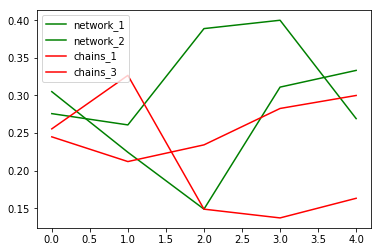

In [266]:
for n in [1,2]:
    chain2jaccard_n,chain2cosine_n,chain2number_words_n = get_within([n],"network")
    plt.plot(pd.DataFrame(chain2jaccard_n).mean(),color="green",label="network_{}".format(n))
for c in [[1,2],[3,4]]:        
    chain2jaccard_between = get_between_chains(c,"chain")
    plt.plot(pd.DataFrame(chain2jaccard_between).mean(),color="red",label="chains_{}".format(c[0]))

plt.legend()

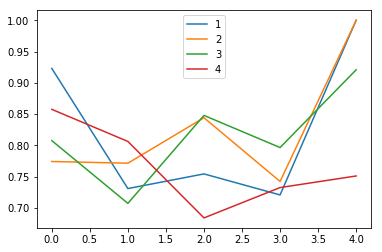

In [268]:
for i in [1,2,3,4]:
    chain2jaccard,chain2cosine,chain2number_words = get_within([i],"chain")
    plt.plot(pd.DataFrame(chain2cosine).mean(),label=str(i))
    #plt.plot(pd.DataFrame(chain2cosine).mean()+pd.DataFrame(chain2cosine).std(),"--",color="gray")
    #plt.plot(pd.DataFrame(chain2cosine).mean()-pd.DataFrame(chain2cosine).std(),"--",color="gray")
plt.legend()

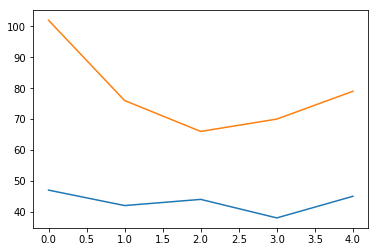

In [270]:
for i in [1,2]:
    chain2jaccard,chain2cosine,chain2number_words = get_within([i],"network")
    plt.plot(pd.DataFrame(chain2number_words).mean())
    #plt.plot(pd.DataFrame(chain2cosine).mean()+pd.DataFrame(chain2cosine).std(),"--",color="gray")
    #plt.plot(pd.DataFrame(chain2cosine).mean()-pd.DataFrame(chain2cosine).std(),"--",color="gray")

## Recall between layers

In [274]:
chain2jaccard,chain2cosine,chain2jaccard_cum,chain2cosine_cum = get_between([1,2,3,4])
chain2jaccard_n,chain2cosine_n,chain2jaccard_cum_n,chain2cosine_cum_n = get_between(chains=[1,2],type_="network")

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


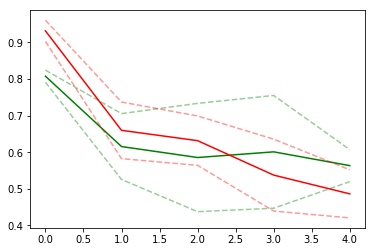

In [275]:
plt.plot(pd.DataFrame(chain2cosine_cum_n).mean(),color="green")
plt.plot(pd.DataFrame(chain2cosine_cum_n).mean()+pd.DataFrame(chain2cosine_cum_n).std(),"--",color="green",alpha=0.4)
plt.plot(pd.DataFrame(chain2cosine_cum_n).mean()-pd.DataFrame(chain2cosine_cum_n).std(),"--",color="green",alpha=0.4)

plt.plot(pd.DataFrame(chain2cosine_cum).mean(),color="red")
plt.plot(pd.DataFrame(chain2cosine_cum).mean()+pd.DataFrame(chain2cosine_cum).std(),"--",color="red",alpha=0.4)
plt.plot(pd.DataFrame(chain2cosine_cum).mean()-pd.DataFrame(chain2cosine_cum).std(),"--",color="red",alpha=0.4)

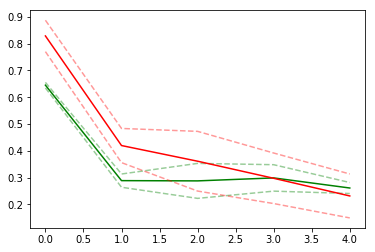

In [276]:
plt.plot(pd.DataFrame(chain2jaccard_cum_n).mean(),color="green")
plt.plot(pd.DataFrame(chain2jaccard_cum_n).mean()+pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="green",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard_cum_n).mean()-pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="green",alpha=0.4)

plt.plot(pd.DataFrame(chain2jaccard_cum).mean(),color="red")
plt.plot(pd.DataFrame(chain2jaccard_cum).mean()+pd.DataFrame(chain2jaccard_cum).std(),"--",color="red",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard_cum).mean()-pd.DataFrame(chain2jaccard_cum).std(),"--",color="red",alpha=0.4)

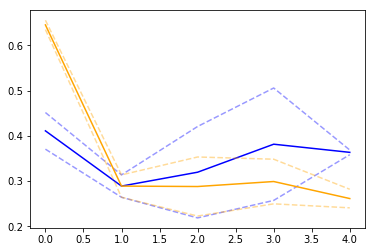

In [277]:
plt.plot(pd.DataFrame(chain2jaccard_n).mean(),color="blue")
plt.plot(pd.DataFrame(chain2jaccard_n).mean()+pd.DataFrame(chain2jaccard_n).std(),"--",color="blue",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard_n).mean()-pd.DataFrame(chain2jaccard_n).std(),"--",color="blue",alpha=0.4)

plt.plot(pd.DataFrame(chain2jaccard_cum_n).mean(),color="orange")
plt.plot(pd.DataFrame(chain2jaccard_cum_n).mean()+pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="orange",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard_cum_n).mean()-pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="orange",alpha=0.4)

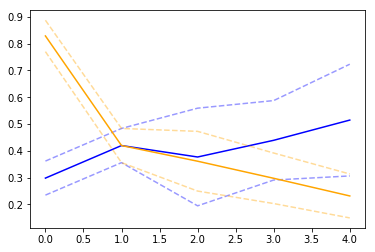

In [278]:
plt.plot(pd.DataFrame(chain2jaccard).mean(),color="blue")
plt.plot(pd.DataFrame(chain2jaccard).mean()+pd.DataFrame(chain2jaccard).std(),"--",color="blue",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard).mean()-pd.DataFrame(chain2jaccard).std(),"--",color="blue",alpha=0.4)

plt.plot(pd.DataFrame(chain2jaccard_cum).mean(),color="orange")
plt.plot(pd.DataFrame(chain2jaccard_cum).mean()+pd.DataFrame(chain2jaccard_cum).std(),"--",color="orange",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard_cum).mean()-pd.DataFrame(chain2jaccard_cum).std(),"--",color="orange",alpha=0.4)